In [95]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors

from tqdm import tqdm

from itertools import permutations
import itertools
import sys

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.stats import binom

np.warnings.filterwarnings('ignore')

In [96]:
"""
This file contains code for conditional entropy forests. 
Adapted from https://github.com/rguo123/conditional_entropy_forests/blob/master/code/algorithm.py
"""

def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_3d_rotation(acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    q = np.random.normal(0,1,4)
    q = q / np.sqrt(np.sum(q**2))
    
    R = np.array([
        [1 -2*(q[2]**2+q[3]**2), 2*(q[1]*q[2]-q[3]*q[0]), 2*(q[1]*q[3]+q[2]*q[0])],
        [2*(q[1]*q[2]+q[3]*q[0]), 1-2*(q[1]**2+q[3]**2), 2*(q[2]*q[3]-q[1]*q[0])],
        [2*(q[1]*q[3] - q[2]*q[0]), 2*(q[2]*q[3]+q[1]*q[0]), 1-2*(q[1]**2+q[2]**2)]
    ])
    return R

def finite_sample_correction(class_probs, row_sums):
    
    where_0 = np.argwhere(class_probs == 0)
    for elem in where_0:
        class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
    where_1 = np.argwhere(class_probs == 1)
    for elem in where_1:
        class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
    return class_probs

def build_model(X, y, n_estimators=200, max_samples=.32,
                                            bootstrap=True,
                                            depth=30,
                                            min_samples_leaf=1):
    if X.ndim == 1:
        raise ValueError('1d data will cause headaches down the road')
        
    max_features = int(np.ceil(np.sqrt(X.shape[1])))
        
    model=BaggingClassifier(DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf,
                                                     max_features = max_features),
                              n_estimators=n_estimators,
                              max_samples=max_samples,
                              bootstrap=bootstrap)
    
    model.fit(X, y)
    return model

def get_leaves(estimator):
    # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold
    
    leaf_ids = []
    stack = [(0, -1)] 
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            leaf_ids.append(node_id)
            
    return np.array(leaf_ids)

def estimate_posteriors(model, train, y, test, in_task=True, subsample=0, acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    n, d = train.shape
    m, d_ = test.shape
    
    if d != d_:
        raise ValueError("train and test data in different dimensions")
    
    class_counts = np.zeros((m, model.n_classes_))
    for tree in model:
        # get out of bag indicies
        if in_task:
            prob_indices = _generate_unsampled_indices(tree.random_state, n)
            # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
        else:
            if subsample:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
            else:
                prob_indices = range(n)
        
        leaf_nodes = get_leaves(tree)
        unique_leaf_nodes = np.unique(leaf_nodes)
            
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

        for prob_index in prob_indices:
            temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
            posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            
        # total number of points in a node
        row_sums = posterior_class_counts.sum(axis=1)
        
        # no divide by zero
        row_sums[row_sums == 0] = 1

        # posteriors
        class_probs = (posterior_class_counts / row_sums[:, None])
        # posteriors with finite sampling correction
        
        class_probs = finite_sample_correction(class_probs, row_sums)
    
        # posteriors as a list
        class_probs.tolist()
        
        partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts / class_counts.sum(axis=1, keepdims=True)
    
    return probs

def predict(a):
    return np.argmax(a, axis = 1)

def permutation(predict1, predict2, force=False):
    """
    how to use:
    
    this function returns the permutation i.e. \pi: [K] -> [K] that maximizes
    the number of matched predictions
    
    to use the permutation for posteriors for point i (posterior_i), say, simply use
    posterior_i[permutation]
    
    """
    unique_1 = np.unique(predict1)
    unique_1_new = np.arange(len(unique_1))
    
    unique_2 = np.unique(predict2)
    unique_2_new = np.arange(len(unique_2))
    
    if force:
        for i, u in enumerate(unique_1_new):
            if u not in unique_2_new:
                unique_2_new = np.concatenate((unique_2_new, [u]))
        
        for i, u in enumerate(unique_2_new):
            if u not in unique_1_new:
                unique_1_new = np.concatenate((unique_1_new, [u]))
    else:
        if set(unique_1) != set(unique_2):
            raise ValueError("predictions must be on the same set of labels")
        
    K = len(unique_1_new)
    
    max_sum = 0
    max_perm = unique_2_new
    for i, perm in enumerate(permutations(unique_2_new)):
        perm = np.array(list(perm))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for k in range(K):
            temp_predict2[np.where(predict2 == unique_2_new[k])[0]] = perm[k]
           
        temp_sum = np.sum(predict1 == temp_predict2)
        if temp_sum > max_sum:
            max_sum = temp_sum
            max_perm = perm
            
    return max_perm
            
def estimate_alpha(predict1, predict2, permutation=None):
    if permutation is None:
        return 2* (np.sum(predict1 == predict2) / len(predict1) - 0.5)
    else:
        unique = np.unique(predict2)
        unique_temp = np.unique(predict1)
        if len(unique) != len(unique_temp):
            unique = np.concatenate((unique, range(len(unique), len(unique) + len(unique_temp) - len(unique_temp))))
        temp_predict2 = -1*np.ones(len(predict2))
        
        for i, k in enumerate(unique):
            print(np.where(predict2 == k)[0])
            print(permutation[i])
            temp_predict2[np.where(predict2 == k)[0]] = permutation[i]
            
        return 2 * (np.sum(predict1 == temp_predict2) / len(predict1) - 0.5)
    
def generate_sample(n, pi, conditional_0, params0, conditional_1, params1, d=2, acorn=None):
    if acorn is None:
        acorn = np.random.seed(10**6)
    np.random.seed(acorn)
    
    n0 = int(np.random.binomial(n, pi))
    n1 = n - n0
    ns = [n0, n1]
    
    X0 = conditional_0(*params0, size=(n0, d))
    
    X1 = conditional_1(*params1, size=(n1, d))
    
    labels = np.concatenate([i*np.ones(ns[i]) for i in range(len(ns))]).astype(int)
    
    return [np.concatenate((X0, X1), axis = 0), labels]

In [97]:
def jovo_experiment(nx, nz, d, dist_x=generate_parity, dist_z=generate_parity, theta=0, m=100, target="Z", subsample = 0.32, n_algos=6, return_ = 0):
    if target == "Z":
        invert_z = True
        invert_x = False
    else:
        invert_z = False
        invert_x = True
        
    Tx = int(np.floor(np.sqrt(nx)))
    Tz = int(np.floor(np.sqrt(nz)))
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)

    # Source task
    X, labelsX = dist_x(nx, d, invert_labels=invert_x)
    testX, test_labelsX = dist_x(m, d, invert_labels=invert_x)

    
    # Target task
    Z, labelsZ = dist_z(nz, d, invert_labels=invert_z)
    testZ, test_labelsZ = dist_z(m, d, invert_labels=invert_z)
    
    if len(X[0, :]) == 2:
        R = generate_2d_rotation(theta)
    else:
        R = generate_3d_rotation()
        
    Z = Z @ R
    testZ = testZ @ R

    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=subsample)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, Z, in_task=False, subsample=subsample)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)
    
#     print(len(pred_structX_estZ), posteriors_structX_estZ.shape)

#     # calculate errors without attempting to transfer knowledge
#     pred_X = predict(posteriors_structX_estX)
#     pred_Z = predict(posteriors_structZ_estZ)

#     errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
#     errors[3] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
#     errors[1] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
#     errors[4] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m

#     # jtv ?
#     pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
#     pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

#     errors[2] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
#     errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    if return_ == 1:
        mesh_ =np.array(list(itertools.product(np.arange(-1, 1+0.05, step=0.05), np.arange(-1, 1+0.05, step=0.05))))
        
        posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, mesh_, in_task=True)
        posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, mesh_, in_task=False, subsample=subsample)

        posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, mesh_, in_task=False, subsample=subsample)
        posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, mesh_, in_task=True)
                    
        return posteriors_structX_estX, posteriors_structZ_estX, posteriors_structZ_estZ, posteriors_structX_estZ
    
    elif return_ == 2:
        print(nz - np.sum(pred_structX_estZ == labelsZ), pred_structX_estZ == labelsZ)
        return nz - np.sum(pred_structX_estZ == labelsZ)
    else:
        return errors

In [98]:
np.random.seed(3)
X, labelsX = generate_parity(500, 2)
temp_labelsX = []
# testX, test_labelsX = generate_parity(m, d)
    
# Target task
Z, labelsZ = generate_parity(650, 2, invert_labels=True)
Z = Z @ generate_2d_rotation(theta=np.pi/4)
temp_labelsZ = []

for i in range(len(labelsX)):
    if labelsX[i] == 0:
        temp_labelsX.append('k')
    else:
        temp_labelsX.append('pink')
       
for i in range(len(labelsZ)):
    if labelsZ[i] == 0:
        temp_labelsZ.append('k')
    else:
        temp_labelsZ.append('pink')

Text(0.5, 1.0, 'R-XOR')

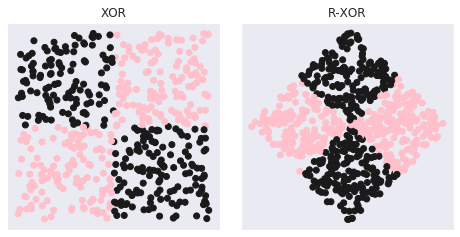

In [99]:
fig1 = plt.figure(figsize=(8,8))
fig1.subplots_adjust(wspace=0.1, hspace=0.1)
ax1 = fig1.add_subplot(2, 2, 1, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax2 = fig1.add_subplot(2, 2, 2, xticklabels=[], yticklabels=[], xticks=[], yticks=[])

ax1.scatter(X[:, 0], X[:, 1], c = temp_labelsX)
ax2.scatter(Z[:, 0], Z[:, 1], c = temp_labelsZ)

ax1.set_title('XOR')
ax2.set_title('R-XOR')

In [100]:
from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

power_its = 10
mc_its = 5 # number of simulation repititions
# ns0 = (10*np.arange(3,5,step=1)).astype(int)
ns = (100*np.arange(0.5, 4.5, step=0.5)).astype(int) # number of training samples 
nz_prop = 1
alpha=0.05

m = 100 # number of test samples each monte carlo iteration
pis = [np.pi/4]
mean_power = np.zeros((len(pis), len(ns)))
std_power = np.zeros((len(pis), len(ns)))

d = 2
for k, pi in enumerate(tqdm(pis)):
    for j, n in enumerate(ns):
        temp_power = []
        for i in range(mc_its):
            condensed_func = lambda x : jovo_experiment(100, x, d, theta=pi, m=m, n_algos=M, return_=2)

            Ts = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(power_its)))
            ps = np.array([binom.cdf(t - 1, n=n, p=0.5) for t in Ts])

            rejections = np.sum(ps < alpha)
            temp_power.append(rejections / power_its)
        
        mean_power[k, j] = np.mean(temp_power)
        std_power[k, j] = np.std(temp_power, ddof=1)












  0%|          | 0/1 [00:00<?, ?it/s]










100%|██████████| 1/1 [00:56<00:00, 56.44s/it]

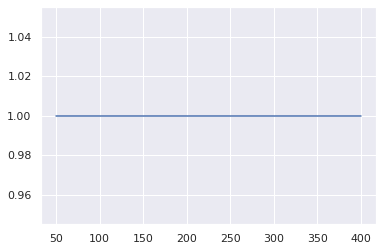

In [101]:
fig, ax = plt.subplots(1,1)

for i, pi in enumerate(pis):
    ax.plot(ns, mean_power[i])
    ax.fill_between(ns, 
            mean_power[i] + 1.96*std_power[i]/np.sqrt(mc_its), 
            mean_power[i] - 1.96*std_power[i]/np.sqrt(mc_its), 
            where=mean_power[i] + 1.96*std_power[i]/np.sqrt(mc_its) >= mean_power[i] - 1.96*std_power[i]/np.sqrt(mc_its), 
            alpha=0.15,
            interpolate=True)